# Proyecto 04 - Reconocimiento de lenguaje de señas

## **Dataset**

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import seaborn as sns
from matplotlib import cm
from collections import Counter
from itertools import product
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import torch
from torch import nn
import torch.optim as optim
import random

### X_data: Matriz de Imágenes

In [7]:
#load
data_test = pd.read_csv('.\data\sign_mnist_test.csv')
data_train = pd.read_csv('.\data\sign_mnist_train.csv')


In [9]:
scaler = MinMaxScaler()


X_train = data_train.iloc[:, 1:].values 
X_test = data_test.iloc[:, 1:].values

X_train = scaler.fit_transform(X_train) # Normalizando los datos
X_test = scaler.fit_transform(X_test) # Normalizando los datos

X_train = torch.from_numpy(X_train).float() # Convirtiendo a tensor
X_test = torch.from_numpy(X_test).float() # Convirtiendo a tensor



In [10]:
print("Cantidad de pixeles: ", data_test.shape[1]-1)
print("Tamaño de cada imagen: ", np.sqrt(data_test.shape[1]-1), " x ", np.sqrt(data_test.shape[1]-1))
print("Cantidad de imagenes de entrenamiento: ", data_train.shape[0])

Cantidad de pixeles:  784
Tamaño de cada imagen:  28.0  x  28.0
Cantidad de imagenes de entrenamiento:  27455


### Label: etiqueta de cada imagen

In [11]:
y_train = data_train.iloc[:, 0].values
y_test = data_test.iloc[:, 0].values

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

np.sort(np.sort(data_train['label'].unique()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

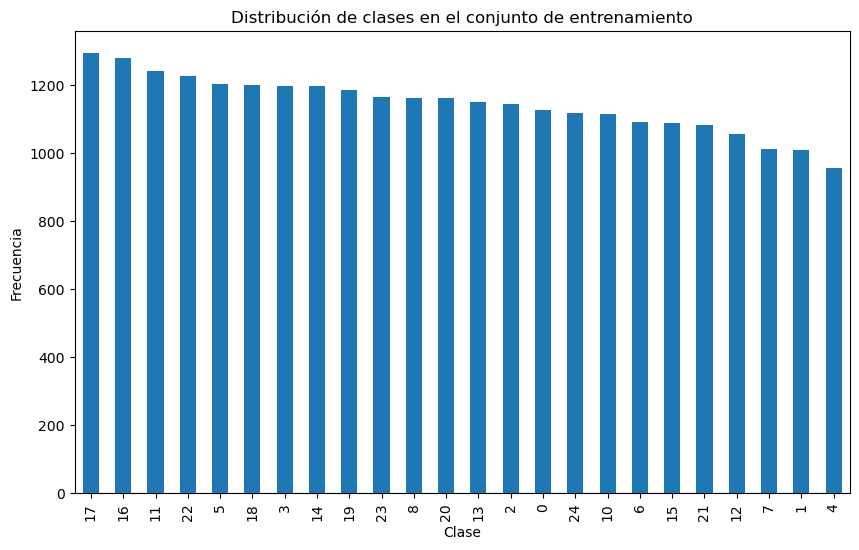

In [12]:
# Conteo de frecuencias de cada clase
train_label_counts = data_train['label'].value_counts()

plt.figure(figsize=(10, 6))
train_label_counts.plot(kind='bar')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

Cada numero representa una letra del abecedario en lenguaje de señas americano (ASL), donde 0 es la letra A y 25 es la letra Z. Debido a que la seña de la letra J=9 y Z=25 requieren movimiento, estas señas se excluyeron del dataset.

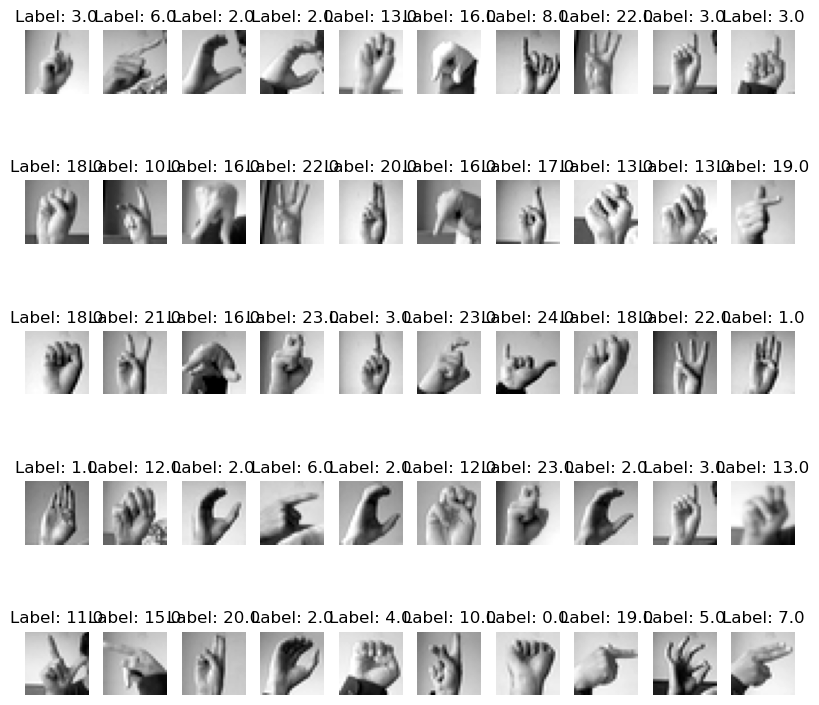

In [13]:
# Crear un mosaico de imágenes
n_rows = 5
n_cols = 10
plt.figure(figsize=(8, 8))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = X_train[i].reshape(28, 28)  # Remodelar a 28x28
    label = y_train[i]
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Convolution**

In [14]:
def Convolution2d(image, kernel, stride, padding):
    image_padded = np.pad(image, pad_width=padding, mode='constant', constant_values=0)

    tam_out_height = int(((image_padded.shape[0] - kernel.shape[0]) / stride) + 1)
    tam_out_width = int(((image_padded.shape[1] - kernel.shape[1]) / stride) + 1)
    
    image_conv = np.zeros((tam_out_height, tam_out_width))

    for i in range(tam_out_height):
        for j in range(tam_out_width):
            image_conv[i, j] = np.sum(image_padded[i*stride:i*stride + kernel.shape[0], j*stride:j*stride + kernel.shape[1]] * kernel)

    return image_conv

In [15]:
def MaxPooling2D(image, pool_size, stride=None,overlap=False):
    if overlap == False:
        stride = pool_size

    out_height = int((image.shape[0] - pool_size) / stride + 1)
    out_width = int((image.shape[1] - pool_size) / stride + 1)

    image_pooled = np.zeros((out_height, out_width))

    for i in range(out_height):
        for j in range(out_width):
            image_pooled[i, j] = np.max(image[i*stride:i*stride + pool_size, j*stride:j*stride + pool_size])

    return image_pooled

## **Kernels**

In [16]:
#Kernels
kernel_identity = np.array([[0,0,0], [0,1,0], [0, 0, 0]])
kernel_blur = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]])
kernel_sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kernel_BottomSobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
kernel_emboss = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
kernel_leftSobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_outline = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
kernel_rightSobel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
kernel_topSobel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

## **MLP**

In [32]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, output_size, activation_function, dropout_rate=0.2):
        super(MLP, self).__init__()
        activation_functions = {
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh(),
            "relu": nn.ReLU()
        }

        if activation_function.lower() not in activation_functions:
            raise ValueError(f"Unsupported activation function: {activation_function}")

        self.activation_function = activation_functions[activation_function.lower()]

        layers = []
        # Input Layer
        layers.append(nn.Linear(input_size, neurons_per_layer))
        layers.append(self.activation_function)


        # Hidden Layers
        for i in range(hidden_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(self.activation_function)
            layers.append(nn.Dropout(dropout_rate))  # Adding dropout to hidden layers


        # Output Layer
        layers.append(nn.Linear(neurons_per_layer, output_size))


        self.layers = nn.Sequential(*layers)
        self.loss_history = None

    def forward(self, x):
      output = self.layers(x)
      return output

    def fit(self, X_train, Y_train, epochs=1000, learning_rate=0.01):
        loss_function = nn.CrossEntropyLoss() #Internally use Softmax function
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        loss_history = []

        for epoch in range(epochs):
          Y_pred = self.forward(X_train)
          loss = loss_function(Y_pred,Y_train.long())
          loss_history.append(loss.item())
          if (epoch%100==0):
            print(f"Epoch {epoch}: train loss: {loss.item()}")

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        self.loss_history = loss_history

    def predict(self, X_test):
        self.eval()

        with torch.no_grad():  # Deactive gradient calc for interference
            Y_pred = self.forward(X_test)

        probs = torch.softmax(Y_pred, dim=1)  # Apply softmax function

        labels = torch.argmax(probs, dim=1)  # Get class with best probability
        return labels

In [33]:
input_size = X_train.shape[1]
hidden_layers = 2
neurons_per_layer = 70
output_size = 25
activation_function = 'relu'

model = MLP(input_size, hidden_layers, neurons_per_layer, output_size, activation_function)

In [34]:
model.fit(X_train, y_train, epochs=1000, learning_rate=0.001)

Epoch 0: train loss: 3.2251996994018555
Epoch 100: train loss: 1.7831834554672241
Epoch 200: train loss: 1.2639421224594116
Epoch 300: train loss: 0.9670068025588989
Epoch 400: train loss: 0.7701383233070374
Epoch 500: train loss: 0.6269059181213379
Epoch 600: train loss: 0.5210850238800049
Epoch 700: train loss: 0.4384460747241974
Epoch 800: train loss: 0.3721449077129364
Epoch 900: train loss: 0.4558892846107483
Epoch 1000: train loss: 0.2675936222076416
Epoch 1100: train loss: 0.23570668697357178
Epoch 1200: train loss: 0.1994411200284958
Epoch 1300: train loss: 0.17088159918785095
Epoch 1400: train loss: 0.15627002716064453


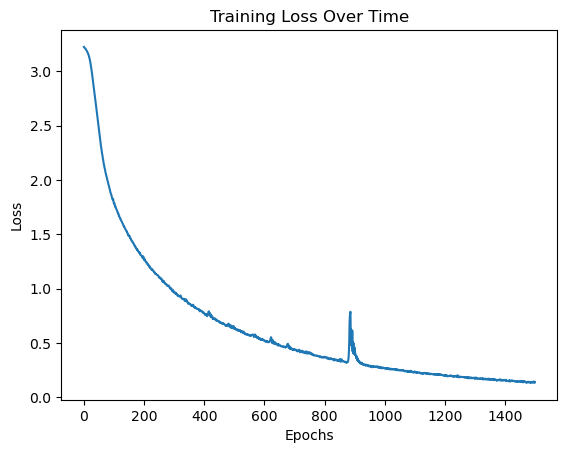

Accuracy: 73.26%


In [35]:
# Graficar la pérdida
plt.plot(model.loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

def calculate_accuracy(model, X_test, Y_test):
    predictions = model.predict(X_test)

    if not isinstance(predictions, np.ndarray):
        predictions = predictions.numpy()
    if not isinstance(Y_test, np.ndarray):
        Y_test = Y_test.numpy()

    correct = (predictions == Y_test).sum().item()
    total = len(Y_test)
    accuracy = correct / total
    return accuracy

accuracy = calculate_accuracy(model, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [36]:
predictions = model.predict(X_test)

comparison = pd.DataFrame({'Real Label': y_test, 'Predicted Label': predictions.numpy()})

print(comparison)

      Real Label  Predicted Label
0            6.0                6
1            5.0                5
2           10.0               10
3            0.0                0
4            3.0                3
...          ...              ...
7167         1.0               20
7168        12.0               18
7169         2.0                2
7170         4.0                4
7171         2.0                2

[7172 rows x 2 columns]


## **CNN**

In [11]:
class CNN(nn.Module):
    def __init__(self, input_size, kernel_name, pool_size, stride, padding, conv_pool_layers, hidden_layers, neurons_per_layer, output_size, activation_function):
        super(CNN, self).__init__()
        
        # Parámetros para las capas de convolución y pooling
        self.kernel_name = kernel_name
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        self.conv_pool_layers = conv_pool_layers
        
        # Calcula el tamaño de la salida después de la convolución y el pooling
        output_after_conv = self.calculate_output_size(input_size)
        
        # Capa MLP
        self.mlp = MLP(output_after_conv, hidden_layers, neurons_per_layer, output_size, activation_function)

    def calculate_output_size(self, input_size):#Solo para imagenes cuadradas
        for i in range(self.conv_pool_layers):
            output_size = ((input_size - self.kernel_name.shape[0] + 2 * self.padding) // self.stride) + 1

            output_size = ((input_size - self.pool_size) // self.pool_size) + 1

            input_size = output_size

        return output_size*output_size
    
    def process_conv_pool(self, X_train):
        X_train_conv = []
        for i in range(X_train.shape[0]):
            image = X_train[i, 1:]
            image = image.reshape(28, 28)
            
            for _ in range(self.conv_pool_layers):
                image_conv = Convolution2d(image, self.kernel_name, self.stride, self.padding)
                
                image_pooled = MaxPooling2D(image_conv, self.pool_size)
                
                image = image_pooled
            
            X_train_conv.append(image_pooled.flatten())

        return X_train_conv

    
    def train(self, X_train, Y_train, epochs=3000, learning_rate=0.01):
        X_train_conv = []
        for i in range(X_train.shape[0]):
            image = X_train[i].reshape(28, 28)
            
            for _ in range(self.conv_pool_layers):
                image_conv = Convolution2d(image, self.kernel_name, self.stride, self.padding)
                
                image_pooled = MaxPooling2D(image_conv, self.pool_size)
                
                image = image_pooled

            X_train_conv.append(image_pooled.flatten())
        
        X_train_conv = np.array(X_train_conv)
        Y_train_conv = np.array(Y_train)
        self.mlp.fit(torch.from_numpy(X_train_conv).float(), torch.from_numpy(Y_train_conv).float(), epochs, learning_rate)

    def mlp_train(self, X_train, Y_train, epochs=3000, learning_rate=0.01):
        self.mlp.fit(X_train, Y_train, epochs, learning_rate)

    def loss_history(self):
        return self.mlp.loss_history
    
    def predict(self, X_test):
        X_test_conv = []
        for i in range(X_test.shape[0]):
            image = X_test[i].reshape(28, 28)

            for _ in range(self.conv_pool_layers):
                image_conv = Convolution2d(image, self.kernel_name, self.stride, self.padding)
                image_pooled = MaxPooling2D(image_conv, self.pool_size)
                image = image_pooled

            X_test_conv.append(image_pooled.flatten())

        X_test_conv = np.array(X_test_conv)

        X_test_tensor = torch.from_numpy(X_test_conv).float()
        logits = self.mlp(X_test_tensor)
        _, predicted_labels = torch.max(logits, 1)

        return predicted_labels

## **Entrenamiento**

In [14]:
input_size = 28 # Tamaño de entrada (por ejemplo, imágenes de 28x28)
kernel_name = kernel_rightSobel
pool_size = 2
stride = 1
padding = 1
conv_pool_layers = 1

hidden_layers = 1
neurons_per_layer = 90
output_size = 25
activation_function = 'relu'

model = CNN(input_size, kernel_name, pool_size, stride, padding, conv_pool_layers, hidden_layers, neurons_per_layer, output_size, activation_function)

In [15]:
model.train(X_train, y_train, epochs=1000, learning_rate=0.01)

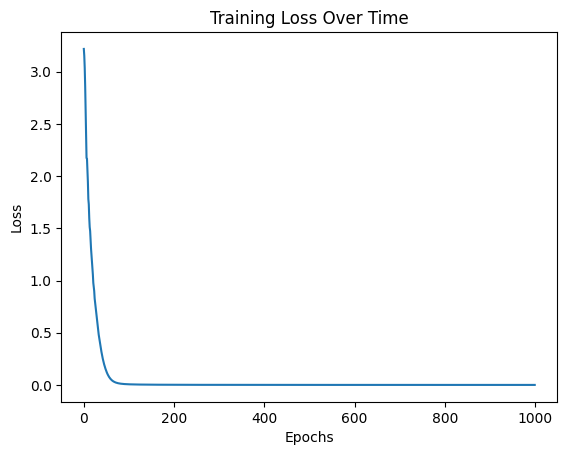

Accuracy: 75.13%


In [16]:
# Graficar la pérdida
plt.plot(model.mlp.loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

def calculate_accuracy(model, X_test, Y_test):
    predictions = model.predict(X_test)

    if not isinstance(predictions, np.ndarray):
        predictions = predictions.numpy()
    if not isinstance(Y_test, np.ndarray):
        Y_test = Y_test.numpy()

    correct = (predictions == Y_test).sum().item()
    total = len(Y_test)
    accuracy = correct / total
    return accuracy

accuracy = calculate_accuracy(model, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [17]:
predictions = model.predict(X_test)

comparison = pd.DataFrame({'Real Label': y_test, 'Predicted Label': predictions.numpy()})

print(comparison)

      Real Label  Predicted Label
0              6                6
1              5                5
2             10               17
3              0                0
4              3                3
...          ...              ...
7167           1                1
7168          12               12
7169           2                2
7170           4                4
7171           2                2

[7172 rows x 2 columns]
